# Auditory BSC

Imports for pylib

In [1]:
from __future__ import division
import sys
import numpy as np
import joblib
import pylab as plt
%matplotlib inline
import glob
from pulp.utils import create_output_path
from pulp.utils.parallel import pprint
from pulp.utils.barstest import generate_bars
from pulp.utils.autotable import AutoTable
import tables
from pulp.utils.parallel import stride_data

from pulp.utils.datalog import dlog, StoreToH5, TextPrinter, StoreToTxt

from pulp.em import EM
from pulp.em.annealing import LinearAnnealing

from pulp.em.camodels.bsc_et import BSC_ET

from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.preprocessing import StandardScaler

plt.rcParams['image.cmap'] = 'viridis'

np.seterr(all='raise')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

## Pre-processing the data

1. Log-Transform of Mel-Spectrogram
2. Extracting image patches
3. Compute and substract intercept
4. Normalize? Before or after extraction?

Import the Mel-Frequency spectrum (MFS) data from the Forrest Gump Audio-Movie

In [2]:
lqmfs_list = glob.glob('data/*.mfs')
feature_list = [np.genfromtxt(lqmfs_fn,delimiter=',') for lqmfs_fn in lqmfs_list]
ft_freq = feature_list[0].shape[1]

Extracts speech patches (for a small part to test) of the log of the MFS data

In [3]:
test_part = np.log(feature_list[0][:2500,:])

patchsize = (16,48)
patches_flat = np.reshape(extract_patches_2d(test_part,patchsize),(test_part.shape[0] - patchsize[0] + 1,-1))

#intercept = np.mean(patches_flat,axis=0)
#patches_flat = patches_flat - intercept

In [6]:
output_path = create_output_path()

N = patches_flat.shape[0]
D = patches_flat.shape[1]

H = 40

Hprime = 6
gamma = 5

model = BSC_ET(D, H, Hprime, gamma, to_learn=['W','sigma','pi'])

data = {'y':patches_flat}


out_fname = output_path + "/data.h5"

In [7]:


#setting up logging/output
print_list = ('T', 'Q', 'pi', 'sigma', 'N', 'MAE', 'L')
dlog.set_handler(print_list, TextPrinter)
h5store_list = ('W', 'pi', 'sigma', 'y', 'MAE', 'N','L','Q')
dlog.set_handler(h5store_list, StoreToH5, output_path +'/result.h5')

###### Initialize model #######
# Initialize (Random) model parameters
model_params = model.standard_init(data)


#### Choose annealing schedule #####
#Linear Annealing
anneal = LinearAnnealing(100)
#Increases variance by a muliplicative factor that slowly goes down to 1
anneal['T'] = [(0., 6.), (.3, 1.)]      # [(iteration, value),... ]
#Reduces truncation rate so as not to prematurely exclude data 
anneal['Ncut_factor'] = [(0, 2.0), (.25, 1.)]     
#Simulated annealing of parameters
anneal['W_noise'] = [(0, 2.0), (.3, 0.0)]
#Include prior parameters in the annealing schedule
anneal['anneal_prior'] = False


# Create and start EM annealing
em = EM(model=model, anneal=anneal)
em.data = data
em.lparams = model_params
em.run()

dlog.close(True)
pprint("Done")

         N = 2482 
         N = 2482 


FloatingPointError: underflow encountered in exp

### Mini-Batch Dictionary Learning

Alternative, since the EM library gives numerical errors

In [20]:
from sklearn.decomposition import MiniBatchDictionaryLearning

mbdic = MiniBatchDictionaryLearning(n_components=30,verbose=True)
mbdic.fit(patches_flat)

[dict_learning] ........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

MiniBatchDictionaryLearning(alpha=1, batch_size=3, dict_init=None,
              fit_algorithm='lars', n_components=30, n_iter=1000, n_jobs=1,
              random_state=None, shuffle=True, split_sign=False,
              transform_algorithm='omp', transform_alpha=None,
              transform_n_nonzero_coefs=None, verbose=True)

### Visualize the dictionary atoms

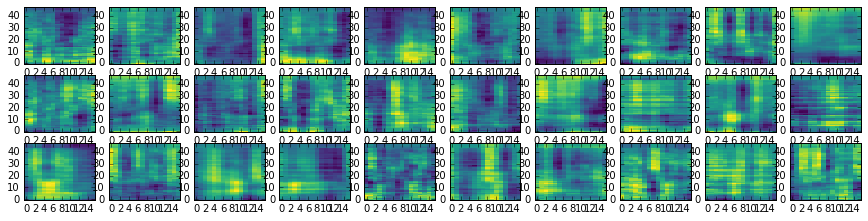

In [21]:
V = mbdic.components_
plt.figure(figsize=(15,12))
for i,comp in enumerate(V):
    plt.subplot(10,10,i+1)
    plt.imshow(comp.reshape(patchsize).T,origin='lower',interpolation='nearest',aspect='auto',cmap='viridis')
    

### Reconstruct some data with the dictionary

In [22]:
transform_algorithm = 'omp'
test_patches = np.reshape(extract_patches_2d(np.log(feature_list[1][500:1000,:]),(16,48)),(-1,16*48))
code = mbdic.transform(test_patches)
reconstructed_patches = np.dot(code, mbdic.components_)


In [23]:
test_patches = np.reshape(test_patches,(-1,16,48))
reconstructed_patches = np.reshape(reconstructed_patches,(-1,16,48))


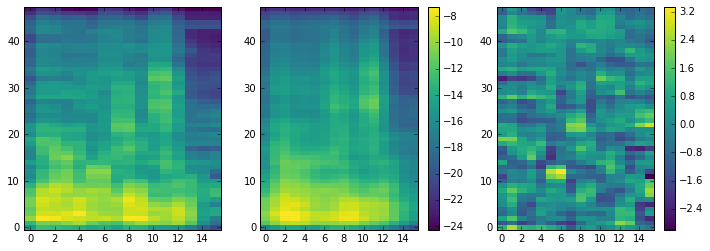

In [12]:
i = 100
imin = min(np.min(test_patches[i]),np.min(reconstructed_patches[i]))
imax = max(np.max(test_patches[i]),np.max(reconstructed_patches[i]))
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(test_patches[i].T,origin='lower',aspect='auto',interpolation='nearest',vmin=imin,vmax=imax)
plt.subplot(1,3,2)
plt.imshow(reconstructed_patches[i].T,origin='lower',aspect='auto',interpolation='nearest',vmin=imin,vmax=imax)
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow((test_patches[i]-reconstructed_patches[i]).T,origin='lower',aspect='auto',interpolation='nearest')
plt.colorbar()

In [24]:
from sklearn.feature_extraction.image import reconstruct_from_patches_2d

stim_tl = reconstruct_from_patches_2d(np.exp(test_patches),(500,48))
rec_tl = reconstruct_from_patches_2d(np.exp(reconstructed_patches),(500,48))

MSE: 1.00932647627e-10


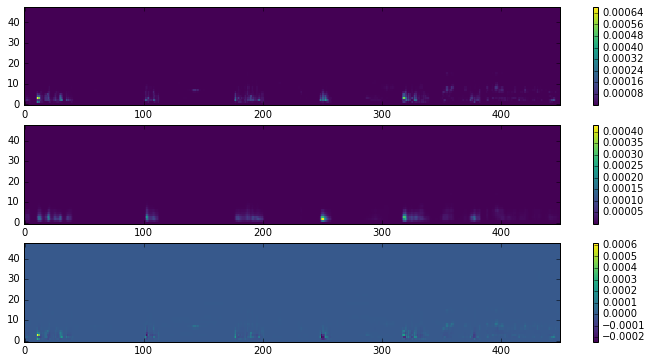

In [25]:
from sklearn.metrics import mean_squared_error

length = 450

plt.figure(figsize=(12,6))
plt.subplot(3,1,1)
plt.imshow(stim_tl[:length].T,origin='lower',aspect='auto',interpolation='nearest')
plt.colorbar()
plt.subplot(3,1,2)
plt.imshow(rec_tl[:length].T,origin='lower',aspect='auto',interpolation='nearest')
plt.colorbar()
plt.subplot(3,1,3)
plt.imshow((stim_tl[:length]-rec_tl[:length]).T,origin='lower',aspect='auto',interpolation='nearest')
plt.colorbar()
print('MSE: {}'.format(mean_squared_error(stim_tl[:length],rec_tl[:length])))

In [ ]:
#normalize them
patch_scaler = preprocessing.StandardScaler()
stimuli_patches = patch_scaler.fit_transform(stimuli_patches)



#%%
nfeat = 15
rpca = decomposition.RandomizedPCA(n_components=nfeat,whiten=True)
rpca.fit(unlagged_stimuli)

unlagged_stimuli = rpca.transform(unlagged_stimuli)

#%%
#sparse pca
spca = decomposition.SparsePCA(n_jobs=-1)
spca.fit(unlagged_stimuli)

unlagged_stimuli = spca.transform(unlagged_stimuli)


#%%
#dictionary minibatch
mbdic = decomposition.MiniBatchDictionaryLearning(n_components=50,verbose=True)
mbdic.fit(stimuli_patches)

#%%
#visualize

V = mbdic.components_
plt.figure()
for i,comp in enumerate(V):
    plt.subplot(10,10,i+1)
    plt.imshow(comp.reshape(patchsize),interpolation='nearest')
    
    
#%%
#now construct code representation for stimuli
codes = mbdic.transform(stimuli_patches[:sum(patch_stim_lens[:100]),:])    
#how are these patches constructed?
#over last dimension first, slide by 1 timepoint
#every ncol-9 move on up (or down if origin is upper left)
#to get time representation, take coefficients up until this time point (watch out there is overlap in patches)
#(so on last dimension) then take all 24 patches on frequency axes (stride by ncol-9)
nlags = 25
lagged_codes = codes_to_stimuli(codes,nstims,nfeat,nlags,patchsize)

#%%
#classify with new data
#first re-create lagged representation from data
nlags = 25

unlagged_stimuli = [ unlagged_stimuli[sum(nstims[:i]):sum(nstims[:i])+nstimsize,:].T  for i,nstimsize in enumerate(nstims) ] 

#lagged_stimuli = [  np.vstack( np.concatenate((np.zeros((nlags-i)*nfeat),stimulus[:,max(0,i-nlags):i].flatten(order='F'))) if i < nlags else stimulus[:,max(0,i-nlags):i].flatten(order='F') for i in xrange(1,stimulus.shape[1]+1) ) for stimulus in unlagged_stimuli ]

new_X = [  np.vstack( np.concatenate((stimulus[:,max(0,i-nlags):i][:,::-1].flatten(order='F'),np.zeros((nlags-i)*nfeat))) if i < nlags else stimulus[:,max(0,i-nlags):i][:,::-1].flatten(order='F') for i in xrange(1,stimulus.shape[1]+1) )[nlags-1:,:] for stimulus in unlagged_stimuli ]

#now stack these vertically
new_X = np.vstack(new_X)

#%%
#standardize again? prob not
predictor_scaler = preprocessing.StandardScaler() 
new_X = predictor_scaler.fit_transform(new_X)

#%%
new_X = np.hstack((np.ones(new_X.shape[0])[:,None],new_X))
train_X,test_X,train_Y,test_Y = train_test_split(new_X,y,test_size=0.3)

In [3]:
#output_path = '/home/mboos/MasterThesis/output/'
output_path = create_output_path()

N = feature_list[0].shape[0]
D = feature_list[0].shape[1]

H = 10

Hprime = 7
gamma = 6

model = BSC_ET(D, H, Hprime, gamma, to_learn=['W','sigma','pi'])

scaler = StandardScaler()
data = {'y':np.log(feature_list[0])}


out_fname = output_path + "/data.h5"

In [42]:
#creates MPI safe output path
output_path = create_output_path()

# Number of datapoints to generate
N = 1000

# Each datapoint is of D = size*size
size = 5

# Diemnsionality of the model
H = 2 * size     # number of latents
D = size ** 2    # dimensionality of observed data

# Approximation parameters for Expectation Truncation
Hprime = 6
gamma = 5

#Instantiate the BSC model
model = BSC_ET(D, H, Hprime, gamma, to_learn=['W','sigma','pi'])


# Model parameters used when artificially generating 
# ground-truth data. This will NOT be used for the learning
# process.
params_gt = {
    'W'     :  10*generate_bars(H),   # this function is in bars-create-data
    'pi'    :  2. / H,
    'sigma' :  1.0
}

# create data
data = model.generate_data(params_gt, N)

# and save results
out_fname = output_path + "/data.h5"
with AutoTable(out_fname) as tbl:

    # Save ground-truth parameters
    for key in params_gt:
        tbl.append(key, params_gt[key])

    # Save generated data
    for key in data:
        tbl.append(key, data[key])
    tbl.close()

In [7]:
#setting up logging/output
print_list = ('T', 'Q', 'pi', 'sigma', 'N', 'MAE', 'L')
dlog.set_handler(print_list, TextPrinter)
h5store_list = ('W', 'pi', 'sigma', 'y', 'MAE', 'N','L','Q')
dlog.set_handler(h5store_list, StoreToH5, output_path +'/result.h5')

###### Initialize model #######
# Initialize (Random) model parameters
model_params = model.standard_init(data)
for param_name in model_params.keys():
    if param_name not in model.to_learn:
        model_params[param_name]=params_gt[param_name]


#### Choose annealing schedule #####
#Linear Annealing
anneal = LinearAnnealing(100)
#Increases variance by a muliplicative factor that slowly goes down to 1
anneal['T'] = [(0., 6.), (.3, 1.)]      # [(iteration, value),... ]
#Reduces truncation rate so as not to prematurely exclude data 
anneal['Ncut_factor'] = [(0, 2.0), (.25, 1.)]     
#Simulated annealing of parameters
anneal['W_noise'] = [(0, 2.0), (.3, 0.0)]
#Include prior parameters in the annealing schedule
anneal['anneal_prior'] = False

In [8]:
# Create and start EM annealing
em = EM(model=model, anneal=anneal)
em.data = data
em.lparams = model_params
em.run()

dlog.close(True)
pprint("Done")

         N = 999 


TypeError: Wrong datatype "int64" for "N" field